---
### Util.

In [1]:
import requests
from bs4 import BeautifulSoup
from IPython.display import HTML
import pyspark as ps
import pandas as pd
import numpy as np
import time

response_cache = {}

def http_get(url):
    if response := response_cache.get(url):
        return response
    else:
        response = requests.request(url=url, method="GET")
        counties_list_html = response.content
        response_cache[url] = counties_list_html
        
        return response_cache[url]

spark = (ps.sql.SparkSession
         .builder
         .master('local[8]')
         .appName('lecture')
         .getOrCreate())

sc = spark.sparkContext

In [3]:
def wikipedia_export_get(title):
    xml = http_get("https://en.wikipedia.org/wiki/Special:Export/" + title)
    
    if b'<redirect title' in xml:
        return wikipedia_export_get(title=BeautifulSoup(xml).select('redirect')[0]['title'])
    else:
        return xml

def wikipedia_standard_url(title):
    return "https://en.wikipedia.org/wiki/" + title

def wikipedia_infobox_key_values(text):
    """
    {{Infobox settlement
    | name = Dooley
    | settlement_type = [[Ghost town]]
    | image_skyline = 
    | imagesize =
    | image_caption = 
    | pushpin_map = Montana#USA
    | pushpin_label_position = left
    | map_caption = Location of Dooley in Montana
    | coordinates_footnotes = <ref>{{cite gnis |id=770722 |name=Dooley}}</ref>
    | subdivision_type = [[List of sovereign states|Country]]
    | subdivision_name = United States
    | subdivision_type1 = [[U.S. state|State]]
    | subdivision_name1 = [[Montana]]
    | subdivision_type2 = [[List of counties in Montana|County]]
    | subdivision_name2 = [[Sheridan County, Montana|Sheridan]]
    | established_title = Established
    | established_date = 1913
    | named_for = 
    | extinct_title = Abandoned
    | extinct_date = 1957
    | elevation_ft = 2461
    | coordinates = {{coord|48|52|52|N|104|23|22|W|region:US-MT|display=inline,title}}
    }}
    """
    
    import re
    
    regex = r"^\s*\|\s*(.+?)\s*=(\s*|(\s*(.*)\s*))$"
    key_values = re.findall(regex, text, re.MULTILINE)

    return [(key, value) for key, _, _, value in key_values]

def wikipedia_infobox_key_values_non_empty(text):
    return [(key, value) for key, value in wikipedia_infobox_key_values(text) if value != '']

---

### Init!

In [26]:
!wc -l data/communities_all.txt

71208 data/communities_all.txt


##### Split list of communities into smaller chunks to make bulk downloads easier
I had trouble doing a bulk download on the whole list.

In [ ]:
# example
cat communities_all.txt | awk 'NR >= 60001 && NR <= 90000 {print}' > communities--60_001--90_000.txt

##### From https://en.wikipedia.org/wiki/Special:Export/

In [4]:
%%time

filenames = ['data/communities--00_001--30_000.xml',
             'data/communities--30_001--60_000.xml',
             'data/communities--60_001--90_000.xml']

pages_parsed = []
for filename in filenames:
    with open(filename) as f:
        parsed = BeautifulSoup(f.read())
        pages_parsed += parsed.select('mediawiki > page')
        
len(pages_parsed)

CPU times: user 1min 57s, sys: 6.41 s, total: 2min 3s
Wall time: 2min 6s


64971

##### Missing
Page doesn't exist, may be a redirect, not be made yet (was a red link), potential typos, etc.

In [5]:
titles_all = sc.textFile('data/communities_all.txt')
titles_parsed = [page.select('title')[0].getText().strip() for page in pages_parsed]

missing = list(set(titles_all.collect()).difference(titles_parsed))

##### Redirects
From missing, find those which are redirects

In [9]:
inner = []
for title in missing[:100]:
    is_redirect = b'<redirect title' in http_get("https://en.wikipedia.org/wiki/Special:Export/" + title)
    inner.append(f'<div style="flex: reflow">(<b>{is_redirect if is_redirect else ""}</b><span style="color: gray">{is_redirect if not is_redirect else ""}</span>, </td><td><a href="{wikipedia_standard_url(title)}">{title}</a>)</div>')
    
HTML('<div style="display: flex; width: 100%; flex-flow: wrap">[' + ',&nbsp;'.join(inner) + ']</div>')

##### Patch Redirects

In [ ]:
redirects = []

print("total", len(missing), "\n----")
for index, title in enumerate(missing):
    is_redirect = b'<redirect title' in http_get("https://en.wikipedia.org/wiki/Special:Export/" + title)
    
    if is_redirect:
        redirects.append(title)
        print(index, title)

In [10]:
redirects = [
    'Prattsburgh (CDP), New York',
    'Jacobs, Ashland County, Wisconsin',
    'Gilmanton, Buffalo County, Wisconsin',
    'East Highland, Michigan',
    'Snyderville, Michigan',
    'Jones, Michigan',
    'Williamsburg, Tennessee',
    'Le Roy, Michigan',
    'Mount Helix, California',
    "Brown's Store, Ohio",
    'Loch Lomond, Florida',
    'Flom Township, Minnesota',
    'Mears, Michigan',
    'Bluff, UT',
    'Elyton, Alabama',
    'Mt. Olive, Oklahoma',
    'Shelby, Macomb County, Michigan',
    'Old Iron Town, Utah',
    'Hawks, Michigan',
    'Waimanalo, Hawaii',
    'Sherman City, Michigan',
    'Gros Cap, Michigan',
    'Fillmore, Michigan',
    'Canton (town), New York',
    'Manset, Maine',
    'Franklin, Venango County, Pennsylvania',
    'White River, Ashland County, Wisconsin',
    'Burr Oak Township, St. Joseph County, Michigan',
    'McVille, Armstrong County, Pennsylvania',
    'Cambridge (town), Vermont',
    'Orogrande, Idaho']

In [11]:
redirects_parsed = [BeautifulSoup(wikipedia_export_get(title)).select('page')[0] for title in redirects]
pages_parsed += redirects_parsed

##### Schema

In [24]:
import pyspark.sql.types as types

schema = types.StructType([
    types.StructField(name='id', dataType=types.LongType(), nullable=False),
    types.StructField(name='Name', dataType=types.StringType(), nullable=False),
    types.StructField(name='XML', dataType=types.StringType(), nullable=False) 
])

data_frame = spark.createDataFrame([(hash("a"), "1😱2", b"c".decode())], schema=schema)
data_frame.toPandas()

,id,Name,XML
0,8052092202930700184,1😱2,c


##### DataFrame

In [451]:
titles_all = [page.select('title')[0].getText().strip() for page in pages_parsed]
triples = zip(map(hash, titles_all), titles_all, map(str, pages_parsed))

data_frame = spark.createDataFrame(triples)

In [453]:
triples = zip(map(hash, titles_all), titles_all, map(str, pages_parsed))
data_frame = spark.createDataFrame(triples)

In [ ]:
data_frame.take(1)

In [ ]:
data_frame.count(), data_frame.distinct().cache().count()

In [ ]:
data_frame.distinct().write.save(path="data/communities_all_70k")

---

#### Key Frequencies

In [12]:
texts_all = [page.select('text')[0].getText() for page in pages_parsed]

In [13]:
len(texts_all), len(set(texts_all))

(65033, 64709)

In [20]:
counting_dict_ = {}
for text in texts_all:
    counting_dict_[text] = counting_dict_.get(text, 0) + 1
    
[tc for tc in counting_dict_.items() if tc[1] > 1][0]

('#REDIRECT [[Austin Township, Sanilac County, Michigan]]\n{{R with possibilities}}\n[[Category:Unincorporated communities in Sanilac County, Michigan]]',
 3)

In [21]:
texts_all = list(set(texts_all))

In [22]:
infoboxes_all = [wikipedia_infobox_key_values_non_empty(text) for text in texts_all]        

In [23]:
info_keys_all = (sc.parallelize(infoboxes_all)
                   .flatMap(lambda keyvalues: [key for key, value in keyvalues]))

In [25]:
key_frequencies = sorted(info_keys_all.countByValue().items(), key=lambda key_count: -key_count[1])
percent = len(texts_all) * 0.01
[kf for kf in key_frequencies if kf[1] > 2*percent]

[('subdivision_type1', 54424),
 ('subdivision_name1', 54421),
 ('subdivision_name', 54416),
 ('subdivision_name2', 54322),
 ('subdivision_type2', 54286),
 ('subdivision_type', 54186),
 ('settlement_type', 54079),
 ('coordinates', 52632),
 ('blank_name', 50808),
 ('utc_offset', 47979),
 ('timezone', 47600),
 ('timezone_DST', 47580),
 ('utc_offset_DST', 47416),
 ('elevation_ft', 46742),
 ('blank_info', 45841),
 ('population_as_of', 42723),
 ('official_name', 40616),
 ('unit_pref', 39687),
 ('area_code', 38075),
 ('population_density_km2', 37940),
 ('population_total', 37658),
 ('postal_code_type', 36898),
 ('map_caption', 35148),
 ('blank1_name', 34181),
 ('area_total_km2', 33692),
 ('area_land_km2', 33592),
 ('area_water_km2', 33298),
 ('image_map', 32747),
 ('postal_code', 32112),
 ('blank1_info', 31836),
 ('area_total_sq_mi', 31502),
 ('area_water_sq_mi', 31451),
 ('area_land_sq_mi', 31360),
 ('population_density_sq_mi', 30179),
 ('pushpin_map', 28754),
 ('elevation_m', 28448),
 ('foo

In [28]:
[(key, frequency) for key, frequency in key_frequencies if 'dat' in key and frequency > 1*percent]

[('established_date', 10543),
 ('accessdate', 8232),
 ('archive-date', 3629),
 ('date', 3574),
 ('established_date2', 2417),
 ('established_date1', 2071),
 ('established_date3', 1484),
 ('archivedate', 906)]

---
#### Search Terms (Misc)

In [60]:
titles_all = [page.select('title')[0].getText().strip() for page in pages_parsed]

In [61]:
tti = (texts_all[:15])
titles_all[5], tti[5]

('Gilbert, Louisiana',
 '{{Infobox settlement\n| name = Gilbert, Louisiana\n| official_name = Village of Gilbert\n| native_name = \n| native_name_lang = \n| other_name = \n| settlement_type = Village\n| image_skyline = Gilbert, LA, City Hall IMG_0321.JPG\n| imagesize = 250px\n| image_alt = \n| image_caption = Gilbert City Hall and Police Department\n| image_flag = \n| image_seal = \n| etymology = \n| nickname = \n| motto = \n| anthem = \n| image_map = File:Franklin Parish Louisiana Incorporated and Unincorporated areas Gilbert Highlighted.svg\n| mapsize = 260px\n| map_alt = \n| map_caption = Location of Gilbert in Franklin Parish, Louisiana.\n| image_map1 = Louisiana in United States (US48).svg\n| mapsize1 = \n| map_alt1 = \n| map_caption1 = Location of Louisiana in the United States\n| pushpin_map = \n| pushpin_label_position = \n| pushpin_label = \n| pushpin_map_alt = \n| pushpin_mapsize = \n| pushpin_relief = \n| pushpin_map_caption = \n| coordinates = {{coord|32|02|59|N|91|39|36|W|

In [51]:
search_terms = ['established_date', 'extinct_date', 'established', 'extinct', 'destroyed']
search_terms += ['mining', 'ghost', 'awesome', 'death', 'taxes', 'high tax', 'low tax',
                 'superhero', 'batman', ' men', ' women', 'spongebob', 'corporations']
search_terms += ['oil', ' oil', 'oil ', ' oil ', 'oil.', '. oil', 'rockefeller']
search_terms += ['gazette', 'journal', 'wall street', 'railroad', 'baron',
                 'polish', 'poland', 'french', 'france', 'film', 'movies', ' media ',
                 'technology', 'farm', 'farming', 'orchard', 'automotive', 'entertainment',
                 'immigrants', 'immigration', 'freelance', 'volcan',
                 'eruption', 'flood', 'tornado', 'hurricane', 'katrina', 'hurricane katrina']

results_dict_ = {}
for search_term in search_terms:
    results_count = sum([1 for text in texts_all if search_term.lower() in text.lower()])
    results_dict_[search_term] = results_count
    
    print(f'{search_term}\t\t{results_count / len(texts_all):0.3f} {results_count}/{len(texts_all)}')

established_date		0.826 53462/64709
extinct_date		0.036 2307/64709
established		0.885 57254/64709
extinct		0.042 2701/64709
destroyed		0.038 2429/64709
mining		0.035 2294/64709
ghost		0.037 2426/64709
awesome		0.000 27/64709
death		0.036 2316/64709
taxes		0.009 598/64709
high tax		0.000 10/64709
low tax		0.000 20/64709
superhero		0.000 17/64709
batman		0.000 23/64709
 men		0.087 5620/64709
 women		0.027 1756/64709
spongebob		0.000 6/64709
corporations		0.008 517/64709
oil		0.047 3030/64709
 oil		0.023 1510/64709
oil 		0.032 2045/64709
 oil 		0.019 1228/64709
oil.		0.003 213/64709
. oil		0.001 68/64709
rockefeller		0.002 121/64709
gazette		0.432 27976/64709
journal		0.069 4437/64709
wall street		0.003 210/64709
railroad		0.184 11915/64709
baron		0.007 457/64709
polish		0.008 531/64709
poland		0.003 207/64709
french		0.042 2709/64709
france		0.017 1080/64709
film		0.050 3227/64709
movies		0.009 591/64709
 media 		0.021 1350/64709
technology		0.021 1376/64709
farm		0.145 9351/64709
farmin

In [53]:
pd.DataFrame([(f'{count / len(texts_all):0.3f}', f'{count} / {len(texts_all)}') for count in results_dict_.values()],
             index=results_dict_.keys()).sort_values(by=0, ascending=False)

,0,1
established,0.885,57254 / 64709
established_date,0.826,53462 / 64709
gazette,0.432,27976 / 64709
railroad,0.184,11915 / 64709
farm,0.145,9351 / 64709
men,0.087,5620 / 64709
journal,0.069,4437 / 64709
film,0.050,3227 / 64709
oil,0.047,3030 / 64709
extinct,0.042,2701 / 64709


In [ ]:
established_dates_ = {}

search_terms = map(str, range(1200, 2100))

for search_term in search_terms:
    results_count = sum([1 for text in texts_all if search_term.lower() in text.lower()])
    established_dates_[search_term] = results_count
    
    print(f'{search_term}\t\t{results_count / len(texts_all):0.5f} {results_count}/{len(texts_all)}')

In [100]:
infoboxes_dicts = [{key: value for key, value in wikipedia_infobox_key_values_non_empty(text)
                    if 'estab' in key} for text in texts_all]

infoboxes_dicts = [dict_ for dict_ in infoboxes_dicts if dict_ != {}]

In [111]:
dates = set([dict_.get('established_date', dict_.get('established')) for dict_ in infoboxes_dicts])
dates.remove(None)

list(dates)[:15]

['May 14, 1875<ref>{{cite web |url=http://sos.iowa.gov/business/pdf/IncCities.pdf  |title=LIST OF INCORPORATED CITIES |page=6 |date=March 16, 2012 |publisher=[[Iowa Secretary of State]] |access-date=August 22, 2013 |url-status=live |archive-url=https://web.archive.org/web/20130415051955/http://sos.iowa.gov/business/pdf/IncCities.pdf |archive-date=April 15, 2013 }}</ref> ',
 "1836<ref name=hellman>Paul Hellman, ''[https://books.google.com/books?id=EQ-R4O2L3nEC&dq=jacksboro,+tennessee+%22andrew+jackson%22&source=gbs_navlinks_s Historical Gazetteer of the United States]'' (Taylor and Francis, 2005), p. 1025.</ref>",
 'January 23, 1956<ref>{{Cite web',
 '1963<ref name=sos>Commonwealth of Kentucky. Office of the Secretary of State. Land Office. "Powderly, Kentucky". Accessed 27 September 2013.</ref>',
 '1927<ref>{{cite web|title=Colmar Manor|url=http://msa.maryland.gov/msa/mdmanual/37mun/colmar/html/c.html|website=Maryland Manual|accessdate=27 June 2017}}</ref>',
 '1832 as Dugas Pasture',
 

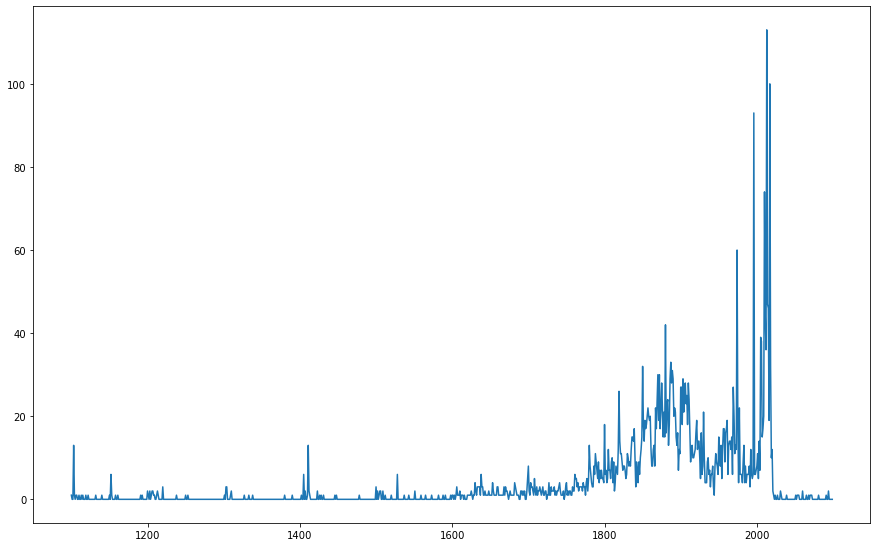

In [134]:
dates = set([dict_.get('established_date', dict_.get('established')) for dict_ in infoboxes_dicts])
dates.remove(None)

search_terms = map(str, range(1100, 2100))

date_results = {}
for search_term in search_terms:
    count = sum([1 for date_text in dates if search_term in date_text.lower()])
    date_results[search_term] = count

fig, ax = plt.subplots(figsize=(0.5*30, 0.5*19))

ax.plot(list(map(int, date_results.keys())), list(date_results.values()))
# ax.fill_between(list(map(int, date_results.keys())), y1=0, y2=list(date_results.values()))

---

#### Investigations

 #### Potential inquiries:
 
 Nearness to rivers/lakes/roads  
 Mining  
 Text quantity as rough measure of significance  
 Dates extract to estimate approximate time

In [24]:
spooky = (data_frame.filter(lambda row: 'ghost' in row.XML.lower())
                    .map(lambda row: row.XML)
                    .cache())

print(spooky.count())
print(BeautifulSoup(spooky.sample(fraction=0.5, withReplacement=False).take(20)[8]).select('text')[0].getText())

86
{{Infobox settlement
|name                     = Tecumseh
|settlement_type          = [[Unincorporated area|Unincorporated community]]

<!-- Images -->
|image_skyline            = Tecumseh, KS.JPG
|image_caption            = Main part of Tecumseh. Church and [[Topeka & Shawnee County Public Library]] bookmobile stop and book drop-off box to the left. [[United States Postal Service]] office to the right.
|image_flag               = 
|image_seal               =

<!-- Maps -->
|image_map                = 
|map_caption              = 
|image_map1               = Map of Shawnee Co, Ks, USA.png
|map_caption1             = [[Kansas Department of Transportation|KDOT]] map of [[Shawnee County, Kansas|Shawnee County]] ([[:File:Kansas official transportation map legend.png|legend]])
|pushpin_map              = Kansas#USA
|pushpin_label            = Tecumseh
|pushpin_label_position   = left <!-- the position of the pushpin label: left, right, top, bottom, none -->
|pushpin_map_caption      = Lo

In [135]:
from IPython.display import HTML
import urllib


def wikipedia_file_url(file):
    # return "https://upload.wikimedia.org/wikipedia/commons/8/81/" + urllib.parse.quote(file, safe=' ').replace(' ', '_')
    return "https://en.wikipedia.org/wiki/Special:FilePath/" + file

file = 'Bellfonte, Alabama- The Chimney of the Local Inn.JPG'
file = 'Reno skyline.JPG'
file = 'Cape dec29-07 (23).JPG'
file = 'Abandoned school in Toyah, Texas.jpg'
HTML(f'<img src="{wikipedia_file_url(file)}" />')

In [ ]:
|settlement_type          = [[Ghost town]]
|settlement_type          = [[Ghost town|Ghost Town]]
|coordinates              = {{coord|34|42|40|N|85|56|43|W|region:US-AL|display=inline,title}}
|coordinates   = {{coord|31|15|21|N|91|36|30|W|region:US-MS|display=inline,title}}

In [ ]:
[[Category:Former populated places in Minnesota]]
[[Category:Former populated places in Rock County, Minnesota]]
[[Category:Ghost towns in Alabama]]
[[Category:Ghost towns in West Texas]]
[[Category:Ghost towns in Nye County, Nevada]]
[[Category:Ghost towns in Nevada]]
[[Category:Former populated places in Adams County, Mississippi]]
[[Category:Former populated places in Mississippi]]
[[Category:Former populated places in Oregon]]
[[Category:Destroyed cities]]
{{US-ghost-town-stub}}

In [ ]:
'''Bellefonte''' is a [[ghost town]]

In [ ]:
==Demographics==
{{US Census population
|1830= 1414
|1840= 1743
|1850= 1761
|1860= 1942
|1870= 1704
|1880= 1767
|1890= 1728
|1900= 1548
|1910= 1644
|1920= 1518
|1930= 1518
|1940= 1700
|1950= 1778
|1960= 2145
|1970= 2505
|1980= 2792
|1990= 2667
|2000= 2692
|2010= 2775
|estyear=2016
|estimate=2783
|estref=<ref name="USCensusEst2016">{{cite web|url=https://www.census.gov/programs-surveys/popest/data/tables.2016.html|title=Population and Housing Unit Estimates|accessdate=June 9, 2017}}</ref>
|footnote=U.S. Decennial Census<ref name="DecennialCensus">{{cite web|url=https://www.census.gov/programs-surveys/decennial-census.html|title=Census of Population and Housing|publisher=Census.gov|accessdate=June 4, 2015}}</ref>
}}

In [ ]:
&lt;!-- Population------------------&gt;
| population_total        = 320
| population_as_of        = 2010
| population_density_km2  = auto
|population_metro         = 

&lt;!-- Population --&gt;
|population_as_of         = 
|population_footnotes     =
|population_total         = 
|population_density_km2   = 
|population_density_sq_mi =

&lt;!-- postal codes, area code --&gt;
| geocode                 = 
| iso_code                = 